Occupancy Detection based on ECO dataset: Winter
=======================================

In [1]:
import sys
import numpy as np
#sys.path.append("c:/python34/lib/site-packages")
import keras
import pandas as pd
from datetime import datetime as dt
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, Conv1D, MaxPooling2D, LSTM, Bidirectional
from keras import regularizers
import keras.callbacks as cb
from matplotlib import pyplot as plt
import random
import scipy.io as sio

Using TensorFlow backend.


The following function normalizes each column of the input array by substracting the mean and dividing by the standard deviation.

In [2]:
def normalize_data(X):
    for i in range(X.shape[1]):
        if np.std(X[:,i]) < 1e-4:
            den = 1e-4
        else:
            den = np.std(X[:,i])
        X[:,i] = (X[:,i]-np.mean(X[:,i]))/den
    return X

This class is used as a callback for the model fit function which is used to calculate and store the losses after each batch iteration.

In [3]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)


The following function plots the losses against the epochs.

In [4]:
def plot_losses(losses):
    plt.plot(losses)
    plt.title('Loss per batch')
    plt.show()

The following function calculates the sad: 

In [5]:
def calc_sad(X):
    sad = 0
#     print(X)
#     print('end of X')
    for i in X.index.tolist():
#         print(i)
        if i < X.last_valid_index():
            sad += abs(X[i] - X[i+1])
    return sad

The following function detects the on-off status:

In [6]:
def detect_onoff(X):
    on_off = 0
    thA = 30
    thT = 30
    timecount = 0
    for i in X.index.tolist():
        if i < X.last_valid_index():
#             print(timecount)
            if abs(X[i] - X[i+1]) >= thA:
                timecount += 1
            else:
                timecount = 0
            if timecount == thT:
                on_off += 1
                timecount = 0
    return on_off

In [7]:
from sklearn.metrics import confusion_matrix
def conf_matrix(X_test,y_test,model):
    y_pred = model.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    # Using matshow here just because it sets the ticks up nicely. imshow is faster.
    im = ax.matshow(cm)
    fig.colorbar(im)

    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
    plt.show()

In [12]:
from os import walk
path = "C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/02_sm_csv/02"
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break

In [13]:
df={}
for filename in f:
    datestamp = filename[:-4].replace("-","")
    #print(datestamp)
    #if int(datestamp) >= 20120715 and int(datestamp) <= 20120825:
    df[datestamp]=pd.read_csv(path+"/"+filename,header=None,names=["powerallphases","powerl1","powerl2","powerl3","currentneutral","currentl1","currentl2",
                                    "currentl3","voltagel1","voltagel2","voltagel3","phaseanglevoltagel2l1",
                                    "phaseanglevoltagel3l1","phaseanglecurrentvoltagel1","phaseanglecurrentvoltagel2",
                                    "phaseanglecurrentvoltagel3"])
len(df)

244

In [14]:
df2 = pd.read_csv("C:/Users/isisuser/Documents/Deep Learning_Purbodayv2/IE594964/REP594965/02_occupancy_csv/02_winter.csv",index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.index = df2.index.strftime('%Y%m%d')
len(df2)

45

In [15]:
import datetime
winter = df2.index.tolist()
df_winter = {}
for key in df.keys():
    if key in winter:
        df_winter[key]=df[key]
len(df_winter)

45

In [16]:
n = 900  #chunk row size
winter_features = pd.DataFrame()
for day, data in df_winter.items():
    list_df_winter = [data[i:i+n] for i in range(0,len(data),n)]
    mean123 = []
    mean1 = []
    mean2 = []
    mean3 = []
    std123 = []
    std1 = []
    std2 = []
    std3 = []
    sad1 = []
    sad2 = []
    sad3 = []
    sad123 = []
    range1 = []
    range2 = []
    range3 = []
    range123 = []
    max123 = []
    max1 = []
    max2 = []
    max3 = []
    min123 = []
    min1 = []
    min2 = []
    min3 = []
    corr123 = []
    corr1 = []
    corr2 = []
    corr3 = []
    onoff123 = []
    onoff1 = []
    onoff2 = []
    onoff3 = []
    
    for chunk in list_df_winter:
        mean123.append(np.mean(chunk['powerallphases']))
        mean1.append(np.mean(chunk['powerl1']))
        mean2.append(np.mean(chunk['powerl2']))
        mean3.append(np.mean(chunk['powerl3']))
        std123.append(np.std(chunk['powerallphases']))
        std1.append(np.std(chunk['powerl1']))
        std2.append(np.std(chunk['powerl2']))
        std3.append(np.std(chunk['powerl3']))
        range123.append(np.amax(chunk['powerallphases'] - np.amin(chunk['powerallphases'])))
        range1.append(np.amax(chunk['powerl1'] - np.amin(chunk['powerl1'])))
        range2.append(np.amax(chunk['powerl2'] - np.amin(chunk['powerl2'])))
        range3.append(np.amax(chunk['powerl3'] - np.amin(chunk['powerl3'])))
        sad123.append(calc_sad(chunk['powerallphases']))
        sad1.append(calc_sad(chunk['powerl1']))
        sad2.append(calc_sad(chunk['powerl2']))
        sad3.append(calc_sad(chunk['powerl3']))
        max123.append(np.amax(chunk['powerallphases']))
        max1.append(np.amax(chunk['powerl1']))
        max2.append(np.amax(chunk['powerl2']))
        max3.append(np.amax(chunk['powerl3']))
        min123.append(np.amin(chunk['powerallphases']))
        min1.append(np.amin(chunk['powerl1']))
        min2.append(np.amin(chunk['powerl2']))
        min3.append(np.amin(chunk['powerl3']))
        corr123.append(chunk['powerallphases'].autocorr(lag=1))
        corr1.append(chunk['powerl1'].autocorr(lag=1))
        corr2.append(chunk['powerl2'].autocorr(lag=1))
        corr3.append(chunk['powerl3'].autocorr(lag=1))
        onoff123.append(detect_onoff(chunk['powerallphases']))
        onoff1.append(detect_onoff(chunk['powerl1']))
        onoff2.append(detect_onoff(chunk['powerl2']))
        onoff3.append(detect_onoff(chunk['powerl3']))
    ptime = list(range(1,97))
    data = pd.DataFrame(np.column_stack((min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,mean3,mean123,
                                            std1,std2,std3,std123,sad1,sad2,sad3,sad123,
                                         corr1,corr2,corr3,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,
                                         range3,range123,ptime)), 
                            columns = ['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])
    
    
    winter_features = winter_features.append(data)
winter_features.loc[winter_features.ptime < 25, 'ptime'] = 0
winter_features.loc[winter_features.ptime > 89, 'ptime'] = 0
winter_features = winter_features.loc[(winter_features['ptime'] >0)]
winter_features['ptime'] = winter_features['ptime'] - 24

winter_features

,min1,min2,min3,min123,max1,max2,max3,max123,mean1,mean2,...,corr123,onoff1,onoff2,onoff3,onoff123,range1,range2,range3,range123,ptime
24,15.150,20.804,0.0,36.302,617.298,21.910,0.0,638.601,77.209902,21.309086,...,0.887025,0.0,0.0,0.0,0.0,602.148,1.106,0.0,602.299,1.0
25,15.168,20.785,0.0,36.093,137.463,22.041,0.0,158.782,67.080864,21.273117,...,0.999018,0.0,0.0,0.0,0.0,122.295,1.256,0.0,122.689,2.0
26,15.210,20.733,0.0,36.239,763.429,21.768,0.0,784.863,37.498934,21.208702,...,0.705225,0.0,0.0,0.0,0.0,748.219,1.035,0.0,748.624,3.0
27,65.528,20.743,0.0,86.763,445.076,163.065,0.0,466.604,150.314579,21.694602,...,0.932878,0.0,0.0,0.0,0.0,379.548,142.322,0.0,379.841,4.0
28,15.497,20.992,0.0,36.827,928.802,21.952,0.0,950.646,60.533340,21.498647,...,0.808265,0.0,0.0,0.0,0.0,913.305,0.960,0.0,913.819,5.0
29,68.153,21.011,0.0,89.792,811.448,22.023,0.0,833.278,113.059389,21.527732,...,0.793852,0.0,0.0,0.0,0.0,743.295,1.012,0.0,743.486,6.0
30,15.358,20.941,0.0,36.637,82.551,22.013,0.0,104.010,24.770813,21.497869,...,0.997580,0.0,0.0,0.0,0.0,67.193,1.072,0.0,67.373,7.0
31,15.479,21.110,0.0,36.920,897.666,21.961,0.0,919.345,88.686367,21.505692,...,0.779991,0.0,0.0,0.0,0.0,882.187,0.851,0.0,882.425,8.0
32,68.159,21.049,0.0,89.499,2072.170,32.806,0.0,2093.700,447.106752,21.667523,...,0.994870,0.0,0.0,0.0,0.0,2004.011,11.757,0.0,2004.201,9.0
33,64.678,20.926,0.0,86.087,1022.470,22.065,0.0,1044.040,123.716092,21.501679,...,0.593835,0.0,0.0,0.0,0.0,957.792,1.139,0.0,957.953,10.0


In [17]:
n = 900

cuml_list = []
for index,row in df2.iterrows():
    occ_winter = []
    list_oc_winter = [row[i:i+n] for i in range(0,len(row),n)]
    for chunk in list_oc_winter:
        occ_winter.append(np.bincount(chunk).argmax())
    occ_winter = occ_winter[24:89]

    cuml_list.extend(occ_winter)
#     print(len(cuml_list))
occ_winter_data = pd.DataFrame(cuml_list, columns = ['occupancy'])
print(occ_winter_data)  
    

      occupancy
0             1
1             1
2             1
3             1
4             1
5             1
6             1
7             1
8             1
9             1
10            1
11            1
12            1
13            1
14            1
15            1
16            0
17            0
18            0
19            0
20            0
21            0
22            0
23            0
24            0
25            0
26            0
27            0
28            0
29            0
...         ...
2895          0
2896          0
2897          0
2898          0
2899          0
2900          0
2901          0
2902          0
2903          0
2904          0
2905          0
2906          0
2907          0
2908          0
2909          0
2910          0
2911          1
2912          1
2913          1
2914          1
2915          1
2916          1
2917          1
2918          1
2919          1
2920          1
2921          1
2922          1
2923          1
2924          1

[2925 r

Replacing all the 'nan' values by '0'

In [18]:
winter_features[np.isnan(winter_features)] = 0

Model with Manual Validation:
-----------

In [19]:
def init_model(features):
    model = Sequential()
    model.add(Conv1D(256, 4, activation="relu",
                    input_shape=(features,1), padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(128, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv1D(64, 4, activation="relu",
                    padding="same", strides=1,kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(32, activation='relu',kernel_initializer="he_uniform"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid',kernel_initializer="he_uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics =['accuracy'])
    return model

Data Pre-processing:


In [20]:
X = np.array(winter_features)
print('X dim: ',X.shape)
y = np.array(occ_winter_data)
print('y dim: ',y.shape)

X = normalize_data(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print('X_train dim: ', X_train.shape)
print('X_tesy dim: ', X_test.shape)
print('y_train dim: ', y_train.shape)
print('y_tesy dim: ', y_test.shape)

X dim:  (2925, 33)
y dim:  (2925, 1)
X_train dim:  (2486, 33, 1)
X_tesy dim:  (439, 33, 1)
y_train dim:  (2486, 1)
y_tesy dim:  (439, 1)


In [21]:
features = X_train.shape[1]
model = init_model(features)
model.summary()

W0830 15:52:11.188082  4692 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 15:52:11.318089  4692 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 15:52:11.322090  4692 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 15:52:11.408095  4692 deprecation_wrapper.py:119] From C:\Users\isisuser\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0830 15:52:11.425096  4692 deprec

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 33, 256)           1280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 256)           1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 33, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 33, 128)           131200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 33, 128)           512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 33, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 33, 64)            32832     
__________

Training and Testing:


Train on 2486 samples, validate on 439 samples
Epoch 1/150
 - 4s - loss: 0.3909 - acc: 0.8319 - val_loss: 0.2619 - val_acc: 0.8770
Epoch 2/150
 - 3s - loss: 0.2647 - acc: 0.8998 - val_loss: 0.2799 - val_acc: 0.8861
Epoch 3/150
 - 3s - loss: 0.2343 - acc: 0.9071 - val_loss: 0.1878 - val_acc: 0.9203
Epoch 4/150
 - 3s - loss: 0.2222 - acc: 0.9055 - val_loss: 0.2026 - val_acc: 0.9021
Epoch 5/150
 - 3s - loss: 0.2231 - acc: 0.9091 - val_loss: 0.2181 - val_acc: 0.9134
Epoch 6/150
 - 3s - loss: 0.2260 - acc: 0.9071 - val_loss: 0.2055 - val_acc: 0.9112
Epoch 7/150
 - 3s - loss: 0.2096 - acc: 0.9115 - val_loss: 0.1867 - val_acc: 0.9248
Epoch 8/150
 - 3s - loss: 0.2089 - acc: 0.9175 - val_loss: 0.1966 - val_acc: 0.9203
Epoch 9/150
 - 3s - loss: 0.1994 - acc: 0.9151 - val_loss: 0.1797 - val_acc: 0.9317
Epoch 10/150
 - 3s - loss: 0.1997 - acc: 0.9171 - val_loss: 0.1916 - val_acc: 0.9089
Epoch 11/150
 - 3s - loss: 0.1785 - acc: 0.9252 - val_loss: 0.1807 - val_acc: 0.9203
Epoch 12/150
 - 3s - loss: 

Epoch 97/150
 - 3s - loss: 0.1283 - acc: 0.9501 - val_loss: 0.1399 - val_acc: 0.9453
Epoch 98/150
 - 3s - loss: 0.1337 - acc: 0.9469 - val_loss: 0.1337 - val_acc: 0.9476
Epoch 99/150
 - 3s - loss: 0.1228 - acc: 0.9497 - val_loss: 0.1373 - val_acc: 0.9453
Epoch 100/150
 - 3s - loss: 0.1262 - acc: 0.9445 - val_loss: 0.1316 - val_acc: 0.9522
Epoch 101/150
 - 3s - loss: 0.1208 - acc: 0.9493 - val_loss: 0.1401 - val_acc: 0.9339
Epoch 102/150
 - 3s - loss: 0.1338 - acc: 0.9425 - val_loss: 0.1305 - val_acc: 0.9453
Epoch 103/150
 - 3s - loss: 0.1355 - acc: 0.9433 - val_loss: 0.1317 - val_acc: 0.9431
Epoch 104/150
 - 3s - loss: 0.1277 - acc: 0.9473 - val_loss: 0.1331 - val_acc: 0.9385
Epoch 105/150
 - 3s - loss: 0.1262 - acc: 0.9481 - val_loss: 0.1333 - val_acc: 0.9453
Epoch 106/150
 - 3s - loss: 0.1281 - acc: 0.9469 - val_loss: 0.1429 - val_acc: 0.9271
Epoch 107/150
 - 3s - loss: 0.1251 - acc: 0.9497 - val_loss: 0.1345 - val_acc: 0.9362
Epoch 108/150
 - 3s - loss: 0.1278 - acc: 0.9481 - val_lo

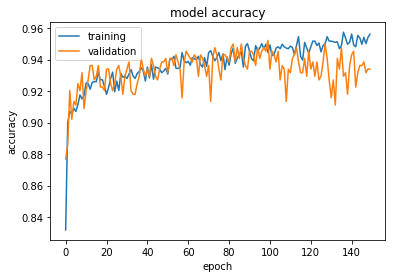

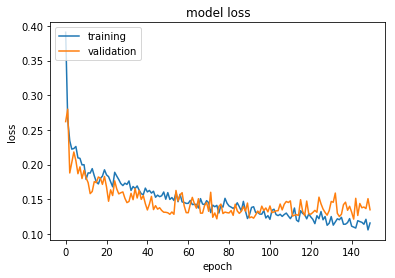

In [22]:
history = LossHistory()
hiss = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[history],
                validation_data=(X_test,y_test), verbose=2)
score = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score)

plt.plot(hiss.history['acc'])
plt.plot(hiss.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss.history['loss'])
plt.plot(hiss.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

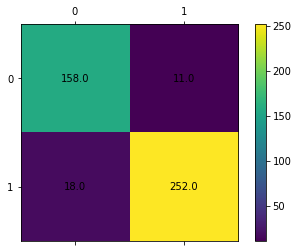

In [23]:
conf_matrix(X_test,y_test,model)

Classification accuracy: 88.86

Early Stopping:
------

In [24]:
model = init_model(features)

Training and Testing:


Train on 2486 samples, validate on 439 samples
Epoch 1/150
 - 5s - loss: 0.3708 - acc: 0.8415 - val_loss: 0.1728 - val_acc: 0.9226
Epoch 2/150
 - 3s - loss: 0.2511 - acc: 0.8974 - val_loss: 0.1799 - val_acc: 0.9362
Epoch 3/150
 - 3s - loss: 0.2348 - acc: 0.9027 - val_loss: 0.1864 - val_acc: 0.9134
Epoch 4/150
 - 3s - loss: 0.2265 - acc: 0.9079 - val_loss: 0.1755 - val_acc: 0.9112
Epoch 5/150
 - 3s - loss: 0.2280 - acc: 0.9079 - val_loss: 0.1918 - val_acc: 0.9066
Epoch 6/150
 - 3s - loss: 0.2140 - acc: 0.9147 - val_loss: 0.1691 - val_acc: 0.9226
Epoch 7/150
 - 3s - loss: 0.1940 - acc: 0.9216 - val_loss: 0.1622 - val_acc: 0.9226
Epoch 8/150
 - 3s - loss: 0.2142 - acc: 0.9123 - val_loss: 0.1595 - val_acc: 0.9294
Epoch 9/150
 - 3s - loss: 0.2020 - acc: 0.9204 - val_loss: 0.1564 - val_acc: 0.9203
Epoch 10/150
 - 3s - loss: 0.1932 - acc: 0.9208 - val_loss: 0.1624 - val_acc: 0.9134
Epoch 11/150
 - 3s - loss: 0.1780 - acc: 0.9248 - val_loss: 0.1806 - val_acc: 0.9089
Epoch 12/150
 - 3s - loss: 

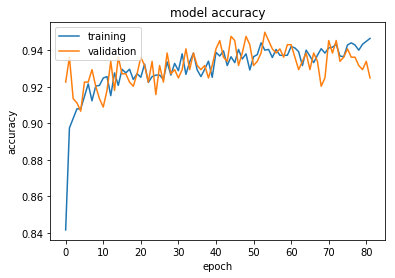

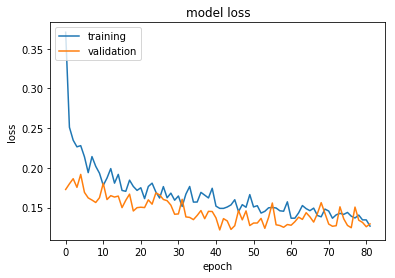

In [25]:
history_e = LossHistory()
es_e = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_e = model.fit(X_train, y_train, epochs=150, batch_size=32,
                callbacks=[history_e,es_e],
                validation_data=(X_test,y_test), verbose=2)
score_e = model.evaluate(X_test, y_test, batch_size=32)
print('loss and accuracy:: ',score_e)

plt.plot(hiss_e.history['acc'])
plt.plot(hiss_e.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_e.history['loss'])
plt.plot(hiss_e.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

Confusion Matrix:

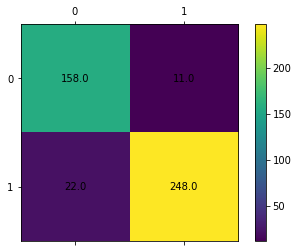

In [26]:
conf_matrix(X_test,y_test,model)

Model with K-fold Validation:
----------

acc: 93.32%


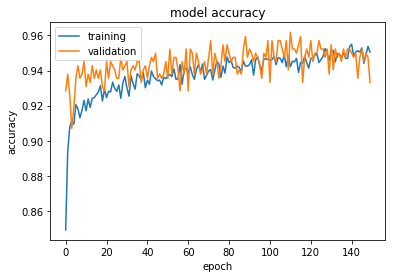

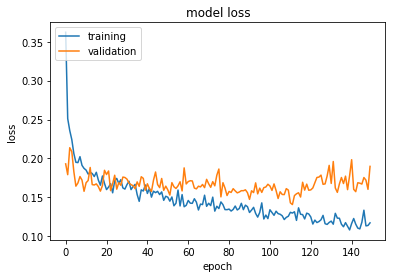

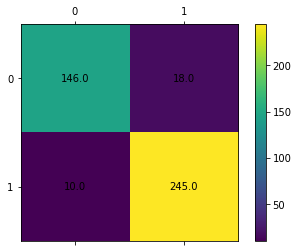

Epoch 00111: early stopping
acc: 92.36%


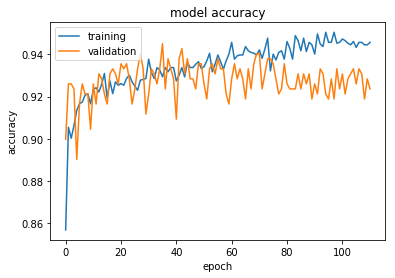

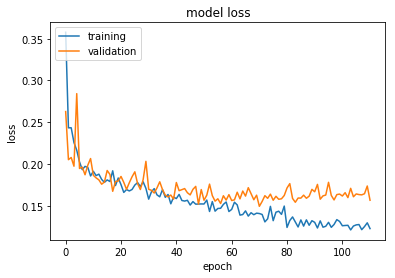

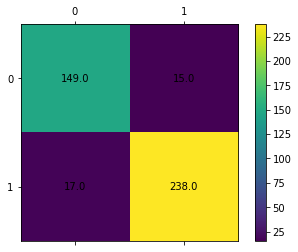

Epoch 00133: early stopping
acc: 94.98%


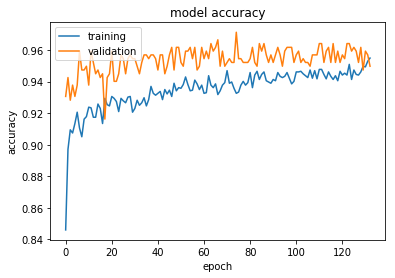

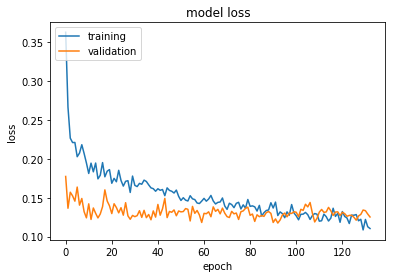

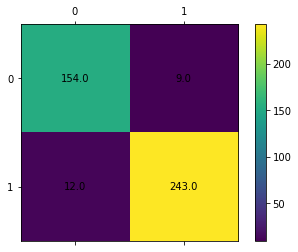

Epoch 00102: early stopping
acc: 93.06%


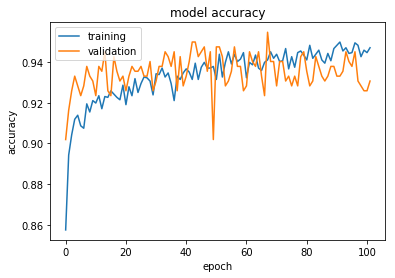

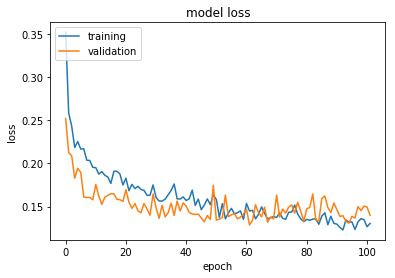

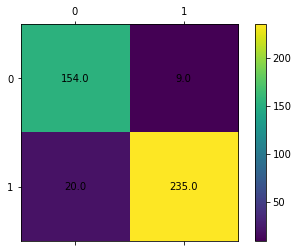

Epoch 00075: early stopping
acc: 91.37%


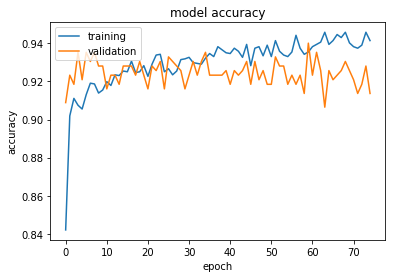

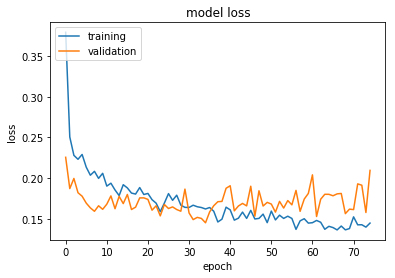

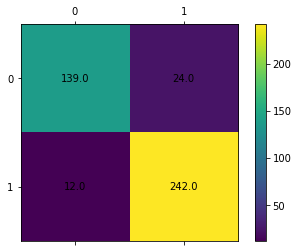

Epoch 00102: early stopping
acc: 92.57%


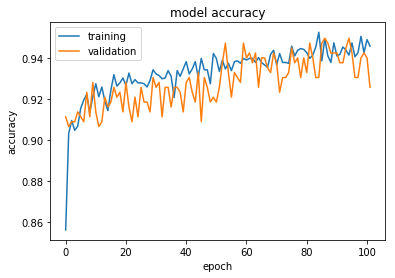

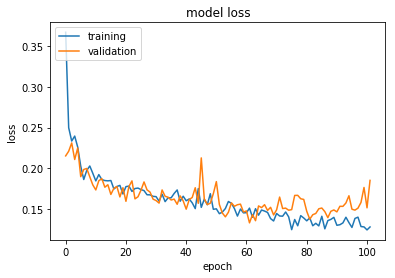

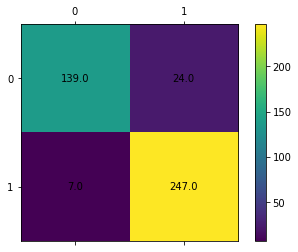

Epoch 00087: early stopping
acc: 92.81%


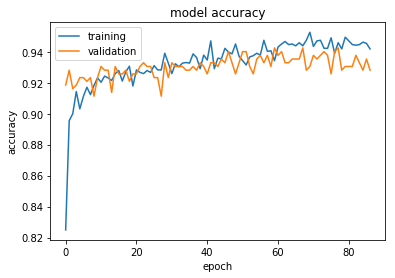

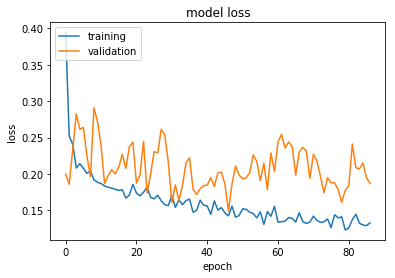

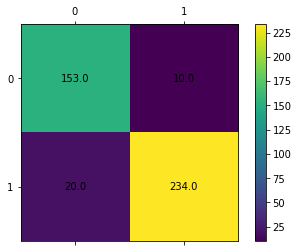

In [27]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
loss = []
for train, test in kfold.split(X, y):
    
    model = init_model(features)
    
    X_train_k =X[train].reshape(X[train].shape[0], X[train].shape[1], 1)
    X_test_k = X[test].reshape(X[test].shape[0], X[test].shape[1], 1)
    history_k = LossHistory()
    es_k = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_k = model.fit(X_train_k, y[train], epochs=150, batch_size=32,
                callbacks=[history_k,es_k],
                validation_data=(X_test_k,y[test]), verbose=0)
    scores_k = model.evaluate(X_test_k, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_k[1]*100))
    cvscores.append(scores_k[1] * 100)
    loss.append(scores_k[0])
#     print(score)
    plt.plot(hiss_k.history['acc'])
    plt.plot(hiss_k.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_k.history['loss'])
    plt.plot(hiss_k.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_k,y[test],model)


In [28]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss), np.std(loss)))

accuracy::  92.92% (+/- 1.02%)
error:: 0.17 (+/- 0.03)


Shapely Values:
-------

In [29]:
import shap

# select a set of background examples to take an expectation over
background = X_train
X_train.shape

(2486, 33, 1)

In [30]:
model = init_model(features)
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
shap_values = e.shap_values(X_train)

In [31]:
shap_values[0]= shap_values[0].reshape(shap_values[0].shape[0],shap_values[0].shape[1])
shap_values[0].shape

X_postprocess = X_train.reshape(X_train.shape[0],X_train.shape[1])
X_postprocess.shape

(2486, 33)

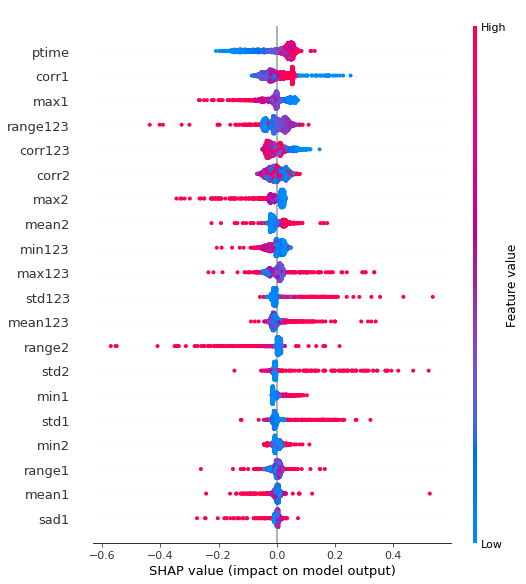

In [32]:
shap.summary_plot(shap_values[0], X_postprocess, feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

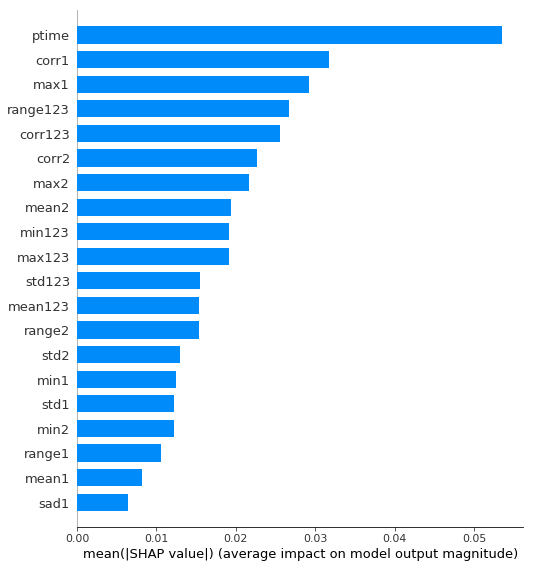

In [33]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar", feature_names=['min1', 'min2', 'min3', 'min123','max1','max2','max3','max123','mean1','mean2','mean3',
                                       'mean123','std1','std2','std3','std123','sad1','sad2','sad3','sad123',
                                         'corr1','corr2','corr3','corr123','onoff1','onoff2','onoff3','onoff123',
                                       'range1','range2','range3','range123','ptime'])

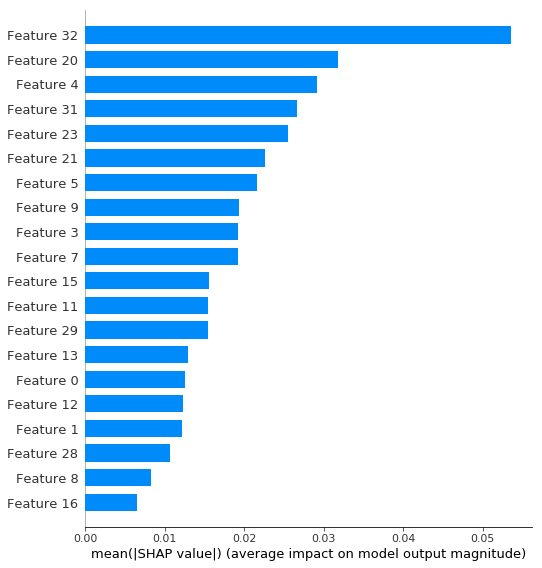

In [34]:
shap.summary_plot(shap_values[0], X_postprocess, plot_type="bar")

After Feature Reduction by Shapely Values
-------------

In [35]:
new_winter_features = np.concatenate((X[:,0:2], X[:,3:6],X[:,7:10],X[:,11:14],X[:,15:17],X[:,20:22],X[:,23][:, np.newaxis],X[:,28:30], X[:,31:33]),axis=1) 
new_winter_features.shape

(2925, 20)

In [36]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(new_winter_features, y, test_size=0.15, shuffle=True)

X_train_s = X_train_s.reshape(X_train_s.shape[0], X_train_s.shape[1], 1)
X_test_s = X_test_s.reshape(X_test_s.shape[0], X_test_s.shape[1], 1)

print('X_train dim: ', X_train_s.shape)
print('X_tesy dim: ', X_test_s.shape)
print('y_train dim: ', y_train_s.shape)
print('y_tesy dim: ', y_test_s.shape)

X_train dim:  (2486, 20, 1)
X_tesy dim:  (439, 20, 1)
y_train dim:  (2486, 1)
y_tesy dim:  (439, 1)


In [37]:
model = init_model(20)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 20, 256)           1280      
_________________________________________________________________
batch_normalization_61 (Batc (None, 20, 256)           1024      
_________________________________________________________________
dropout_61 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 20, 128)           131200    
_________________________________________________________________
batch_normalization_62 (Batc (None, 20, 128)           512       
_________________________________________________________________
dropout_62 (Dropout)         (None, 20, 128)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 20, 64)            32832     
__________

Train on 2486 samples, validate on 439 samples
Epoch 1/150
 - 5s - loss: 0.3761 - acc: 0.8407 - val_loss: 0.2182 - val_acc: 0.9226
Epoch 2/150
 - 2s - loss: 0.2722 - acc: 0.8870 - val_loss: 0.1950 - val_acc: 0.9339
Epoch 3/150
 - 2s - loss: 0.2253 - acc: 0.9087 - val_loss: 0.1874 - val_acc: 0.9339
Epoch 4/150
 - 2s - loss: 0.2348 - acc: 0.9043 - val_loss: 0.1951 - val_acc: 0.9248
Epoch 5/150
 - 2s - loss: 0.2212 - acc: 0.9091 - val_loss: 0.1852 - val_acc: 0.9317
Epoch 6/150
 - 2s - loss: 0.1966 - acc: 0.9200 - val_loss: 0.1793 - val_acc: 0.9339
Epoch 7/150
 - 2s - loss: 0.2024 - acc: 0.9183 - val_loss: 0.1624 - val_acc: 0.9408
Epoch 8/150
 - 2s - loss: 0.2031 - acc: 0.9135 - val_loss: 0.1760 - val_acc: 0.9385
Epoch 9/150
 - 2s - loss: 0.1844 - acc: 0.9175 - val_loss: 0.1681 - val_acc: 0.9408
Epoch 10/150
 - 2s - loss: 0.1943 - acc: 0.9175 - val_loss: 0.1699 - val_acc: 0.9362
Epoch 11/150
 - 2s - loss: 0.1911 - acc: 0.9220 - val_loss: 0.1576 - val_acc: 0.9408
Epoch 12/150
 - 2s - loss: 

Epoch 97/150
 - 2s - loss: 0.1262 - acc: 0.9517 - val_loss: 0.1515 - val_acc: 0.9499
Epoch 98/150
 - 2s - loss: 0.1266 - acc: 0.9453 - val_loss: 0.1506 - val_acc: 0.9453
Epoch 99/150
 - 2s - loss: 0.1276 - acc: 0.9409 - val_loss: 0.1566 - val_acc: 0.9408
Epoch 100/150
 - 2s - loss: 0.1179 - acc: 0.9505 - val_loss: 0.1550 - val_acc: 0.9431
Epoch 101/150
 - 2s - loss: 0.1238 - acc: 0.9509 - val_loss: 0.1585 - val_acc: 0.9499
Epoch 102/150
 - 2s - loss: 0.1086 - acc: 0.9525 - val_loss: 0.1584 - val_acc: 0.9544
Epoch 103/150
 - 2s - loss: 0.1204 - acc: 0.9493 - val_loss: 0.1517 - val_acc: 0.9453
Epoch 104/150
 - 2s - loss: 0.1169 - acc: 0.9533 - val_loss: 0.1576 - val_acc: 0.9431
Epoch 105/150
 - 2s - loss: 0.1137 - acc: 0.9525 - val_loss: 0.1722 - val_acc: 0.9362
Epoch 106/150
 - 2s - loss: 0.1244 - acc: 0.9477 - val_loss: 0.1606 - val_acc: 0.9362
Epoch 107/150
 - 2s - loss: 0.1169 - acc: 0.9497 - val_loss: 0.1538 - val_acc: 0.9453
Epoch 108/150
 - 2s - loss: 0.1083 - acc: 0.9517 - val_lo

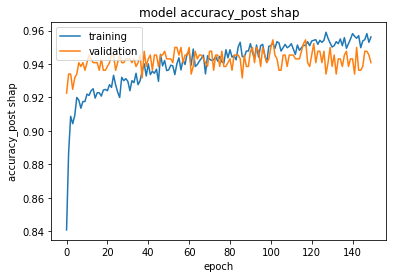

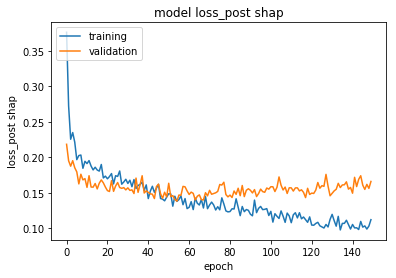

In [38]:
history1 = LossHistory()
hiss1 = model.fit(X_train_s, y_train_s, epochs=150, batch_size=32,
                callbacks=[history1],
                validation_data=(X_test_s,y_test_s), verbose=2)
score1 = model.evaluate(X_test_s, y_test_s, batch_size=32)
print(score1)
plt.plot(hiss1.history['acc'])
plt.plot(hiss1.history['val_acc'])
plt.title('model accuracy_post shap')
plt.ylabel('accuracy_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss1.history['loss'])
plt.plot(hiss1.history['val_loss'])
plt.title('model loss_post shap')
plt.ylabel('loss_post shap')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

y_pred = model.predict(X_test_s)

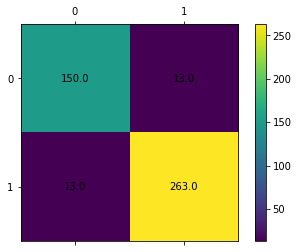

In [39]:
conf_matrix(X_test_s,y_test_s,model)

Early Stopping:
------

Train on 2486 samples, validate on 439 samples
Epoch 1/150
 - 5s - loss: 0.3793 - acc: 0.8375 - val_loss: 0.2336 - val_acc: 0.9157
Epoch 2/150
 - 2s - loss: 0.2596 - acc: 0.8974 - val_loss: 0.1977 - val_acc: 0.9294
Epoch 3/150
 - 2s - loss: 0.2385 - acc: 0.9051 - val_loss: 0.1793 - val_acc: 0.9362
Epoch 4/150
 - 2s - loss: 0.2191 - acc: 0.9039 - val_loss: 0.1875 - val_acc: 0.9362
Epoch 5/150
 - 2s - loss: 0.2214 - acc: 0.9079 - val_loss: 0.1831 - val_acc: 0.9408
Epoch 6/150
 - 2s - loss: 0.2098 - acc: 0.9103 - val_loss: 0.1633 - val_acc: 0.9339
Epoch 7/150
 - 2s - loss: 0.1970 - acc: 0.9191 - val_loss: 0.1719 - val_acc: 0.9362
Epoch 8/150
 - 2s - loss: 0.2032 - acc: 0.9099 - val_loss: 0.1730 - val_acc: 0.9362
Epoch 9/150
 - 2s - loss: 0.2040 - acc: 0.9183 - val_loss: 0.1661 - val_acc: 0.9339
Epoch 10/150
 - 2s - loss: 0.1892 - acc: 0.9151 - val_loss: 0.1751 - val_acc: 0.9362
Epoch 11/150
 - 2s - loss: 0.1777 - acc: 0.9232 - val_loss: 0.1660 - val_acc: 0.9408
Epoch 12/150
 - 2s - loss: 

Epoch 97/150
 - 2s - loss: 0.1203 - acc: 0.9481 - val_loss: 0.1464 - val_acc: 0.9476
Epoch 98/150
 - 2s - loss: 0.1242 - acc: 0.9477 - val_loss: 0.1532 - val_acc: 0.9408
Epoch 99/150
 - 2s - loss: 0.1324 - acc: 0.9461 - val_loss: 0.1530 - val_acc: 0.9453
Epoch 100/150
 - 2s - loss: 0.1258 - acc: 0.9437 - val_loss: 0.1460 - val_acc: 0.9476
Epoch 101/150
 - 2s - loss: 0.1253 - acc: 0.9449 - val_loss: 0.1509 - val_acc: 0.9453
Epoch 102/150
 - 2s - loss: 0.1187 - acc: 0.9449 - val_loss: 0.1504 - val_acc: 0.9499
Epoch 103/150
 - 2s - loss: 0.1194 - acc: 0.9493 - val_loss: 0.1521 - val_acc: 0.9431
Epoch 104/150
 - 2s - loss: 0.1189 - acc: 0.9457 - val_loss: 0.1554 - val_acc: 0.9476
Epoch 105/150
 - 2s - loss: 0.1138 - acc: 0.9457 - val_loss: 0.1531 - val_acc: 0.9453
Epoch 106/150
 - 2s - loss: 0.1211 - acc: 0.9449 - val_loss: 0.1530 - val_acc: 0.9476
Epoch 107/150
 - 2s - loss: 0.1114 - acc: 0.9529 - val_loss: 0.1547 - val_acc: 0.9317
Epoch 108/150
 - 2s - loss: 0.1301 - acc: 0.9493 - val_lo

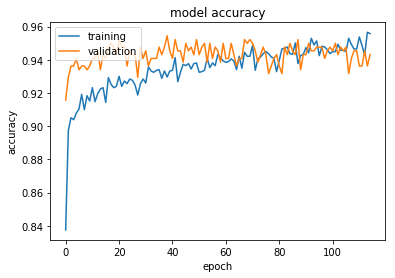

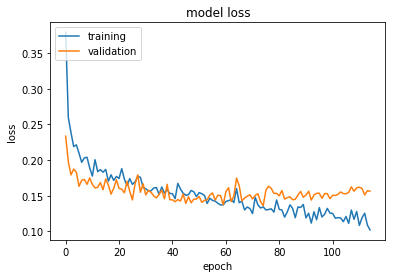

In [40]:
model = init_model(20)

history_se = LossHistory()
es_se = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_se = model.fit(X_train_s, y_train_s, epochs=150, batch_size=32,
                callbacks=[history,es_se],
                validation_data=(X_test_s,y_test_s), verbose=2)
score_se = model.evaluate(X_test_s, y_test_s, batch_size=32)
print('loss and accuracy:: ',score_se)

plt.plot(hiss_se.history['acc'])
plt.plot(hiss_se.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_se.history['loss'])
plt.plot(hiss_se.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

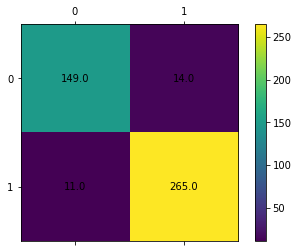

In [41]:
conf_matrix(X_test_s,y_test_s,model)

K-Fold:
---

acc: 95.70%


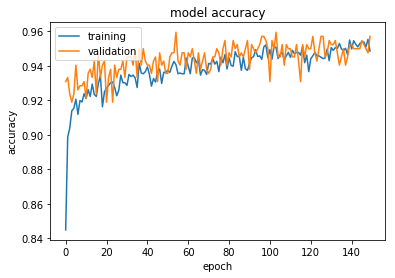

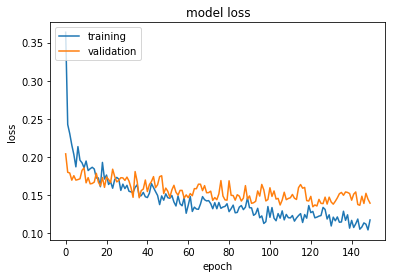

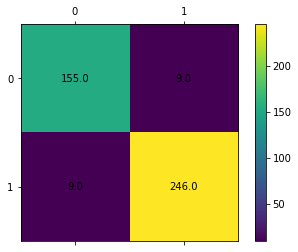

Epoch 00089: early stopping
acc: 92.60%


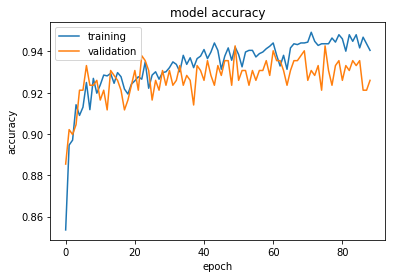

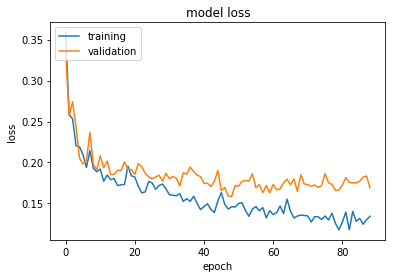

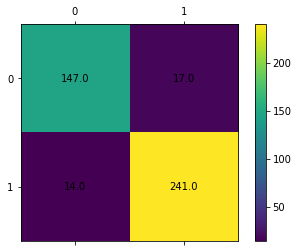

Epoch 00111: early stopping
acc: 95.22%


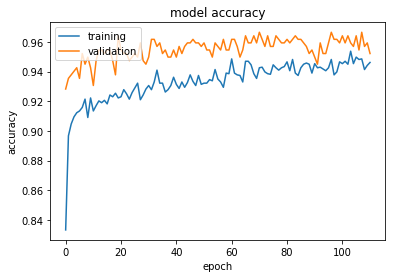

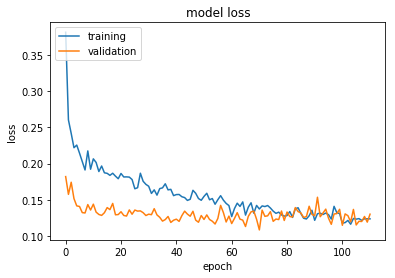

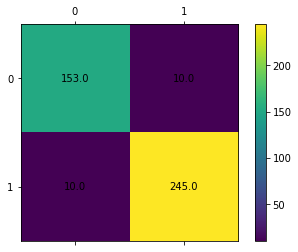

Epoch 00118: early stopping
acc: 92.34%


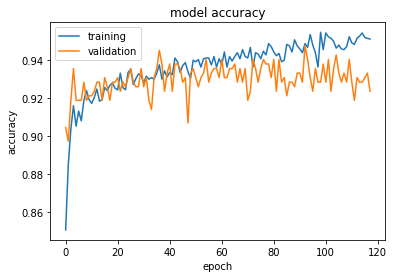

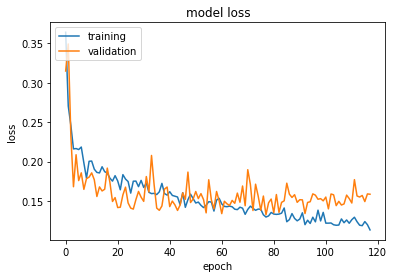

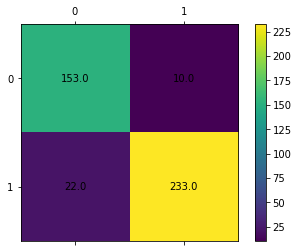

Epoch 00103: early stopping
acc: 93.05%


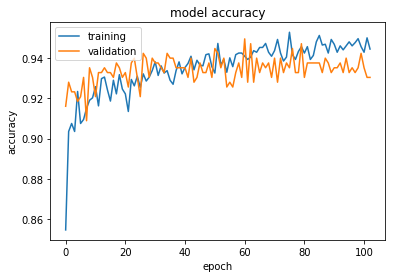

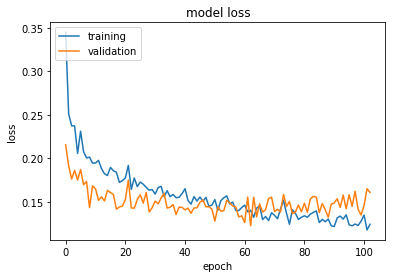

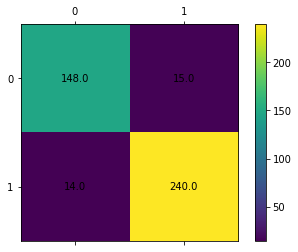

Epoch 00107: early stopping
acc: 94.72%


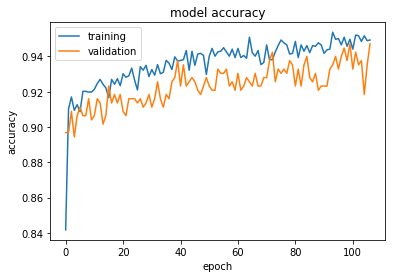

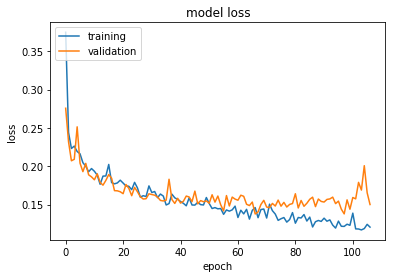

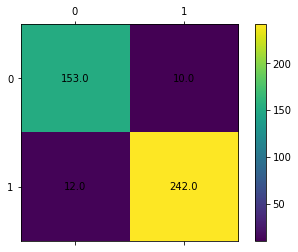

Epoch 00092: early stopping
acc: 94.48%


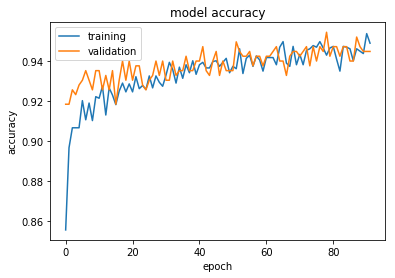

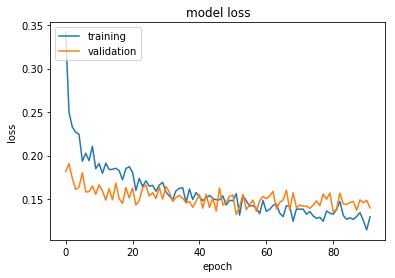

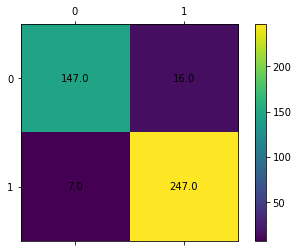

In [42]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold_s = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores_s = []
loss_s = []
XX = new_winter_features
for train, test in kfold_s.split(XX, y):
    
    model = init_model(20)
    
    X_train_ks =XX[train].reshape(XX[train].shape[0], XX[train].shape[1], 1)
    X_test_ks = XX[test].reshape(XX[test].shape[0], XX[test].shape[1], 1)
    history_ks = LossHistory()
    es_ks = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_ks = model.fit(X_train_ks, y[train], epochs=150, batch_size=32,
                callbacks=[history_ks,es_ks],
                validation_data=(X_test_ks,y[test]), verbose=0)
    scores_ks = model.evaluate(X_test_ks, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_ks[1]*100))
    cvscores_s.append(scores_ks[1] * 100)
    loss_s.append(scores_ks[0])
#     print(score)
    plt.plot(hiss_ks.history['acc'])
    plt.plot(hiss_ks.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_ks.history['loss'])
    plt.plot(hiss_ks.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_ks,y[test],model)

In [43]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_s), np.std(cvscores_s)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss_s), np.std(loss_s)))

accuracy::  94.02% (+/- 1.24%)
error:: 0.15 (+/- 0.01)


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 94.27%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 92.36%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 94.26%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 93.06%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 92.09%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.13%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.61%
92.68% (+/- 1.15%)


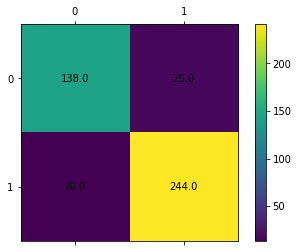

In [56]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score 
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(XX, y):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = XX[train]
    X_test = XX[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, y[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(y[test], y_pred)
    acc = accuracy_score(y[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()

PCA:
-------

In [44]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.99)

In [45]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [46]:
pca.n_components_

11

In [47]:
winter_pca = pca.transform(X)

In [48]:
winter_pca.shape

(2925, 11)

In [49]:
from sklearn.model_selection import train_test_split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(winter_pca, y, test_size=0.15, shuffle=True)

In [50]:
X_train_p.shape

(2486, 11)

Early Stopping:
------

In [51]:
features_p = X_train_p.shape[1]
model = init_model(features_p)

X_train_p = X_train_p.reshape(X_train_p.shape[0], X_train_p.shape[1], 1)
X_test_p = X_test_p.reshape(X_test_p.shape[0], X_test_p.shape[1], 1)

print('X_train dim: ', X_train_p.shape)
print('X_tesy dim: ', X_test_p.shape)
print('y_train dim: ', y_train_p.shape)
print('y_tesy dim: ', y_test_p.shape)

X_train dim:  (2486, 11, 1)
X_tesy dim:  (439, 11, 1)
y_train dim:  (2486, 1)
y_tesy dim:  (439, 1)


Train on 2486 samples, validate on 439 samples
Epoch 1/150
 - 6s - loss: 0.4014 - acc: 0.8162 - val_loss: 0.2912 - val_acc: 0.8929
Epoch 2/150
 - 1s - loss: 0.2805 - acc: 0.8821 - val_loss: 0.2312 - val_acc: 0.8929
Epoch 3/150
 - 1s - loss: 0.2434 - acc: 0.8970 - val_loss: 0.2498 - val_acc: 0.8929
Epoch 4/150
 - 1s - loss: 0.2584 - acc: 0.8982 - val_loss: 0.2376 - val_acc: 0.8929
Epoch 5/150
 - 1s - loss: 0.2294 - acc: 0.9107 - val_loss: 0.1998 - val_acc: 0.9021
Epoch 6/150
 - 1s - loss: 0.2213 - acc: 0.9083 - val_loss: 0.2065 - val_acc: 0.8998
Epoch 7/150
 - 1s - loss: 0.2085 - acc: 0.9143 - val_loss: 0.1921 - val_acc: 0.9157
Epoch 8/150
 - 1s - loss: 0.2171 - acc: 0.9087 - val_loss: 0.1835 - val_acc: 0.9157
Epoch 9/150
 - 1s - loss: 0.2138 - acc: 0.9167 - val_loss: 0.1851 - val_acc: 0.9043
Epoch 10/150
 - 1s - loss: 0.2093 - acc: 0.9135 - val_loss: 0.1921 - val_acc: 0.9112
Epoch 11/150
 - 1s - loss: 0.2011 - acc: 0.9179 - val_loss: 0.1901 - val_acc: 0.9021
Epoch 12/150
 - 1s - loss: 

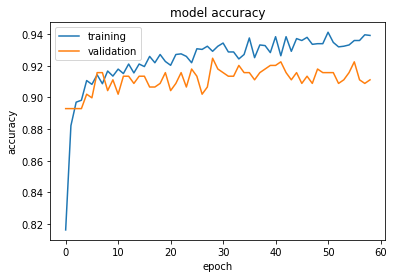

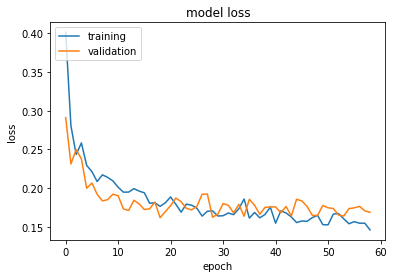

In [52]:
history_pe = LossHistory()
es_pe = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
hiss_pe = model.fit(X_train_p, y_train_p, epochs=150, batch_size=32,
                callbacks=[history_pe,es_pe],
                validation_data=(X_test_p,y_test_p), verbose=2)
score_pe = model.evaluate(X_test_p, y_test_p, batch_size=32)
print('loss and accuracy:: ',score_pe)

plt.plot(hiss_pe.history['acc'])
plt.plot(hiss_pe.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()
plt.plot(hiss_pe.history['loss'])
plt.plot(hiss_pe.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

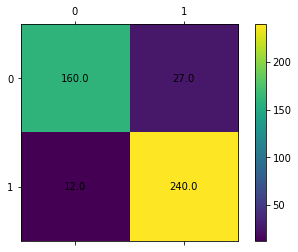

In [53]:
conf_matrix(X_test_p,y_test_p,model)

K-Fold:
---

Epoch 00100: early stopping
acc: 95.23%


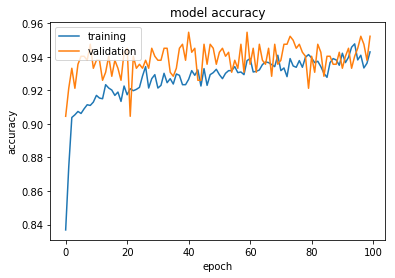

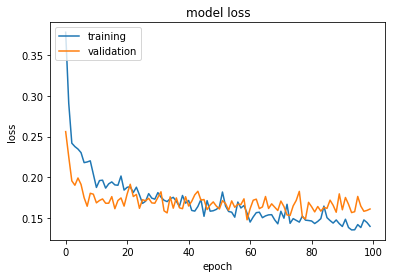

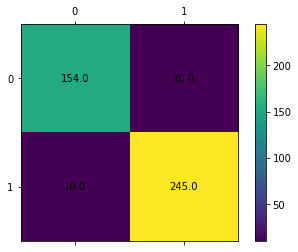

Epoch 00120: early stopping
acc: 92.12%


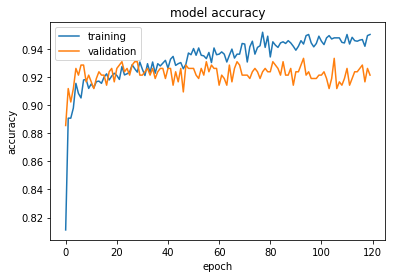

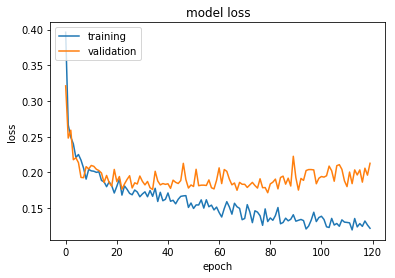

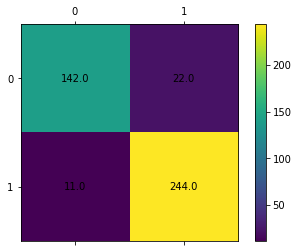

Epoch 00058: early stopping
acc: 94.26%


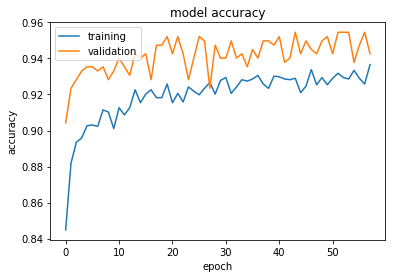

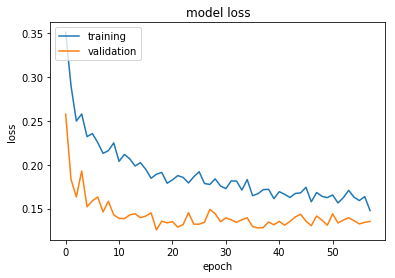

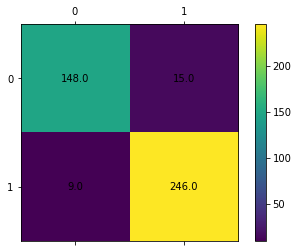

Epoch 00132: early stopping
acc: 94.02%


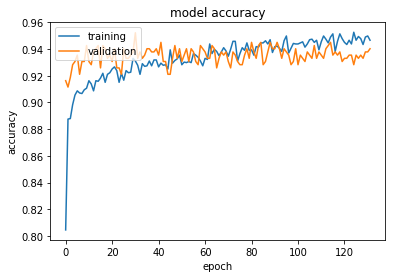

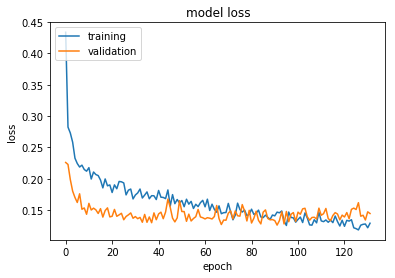

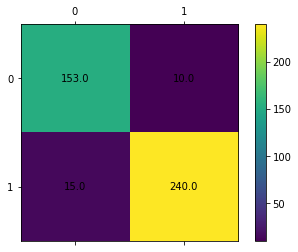

Epoch 00129: early stopping
acc: 93.29%


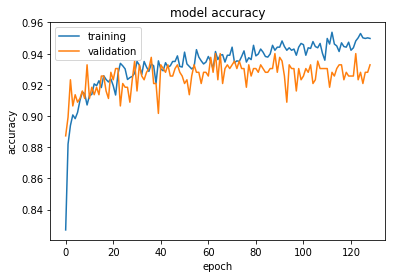

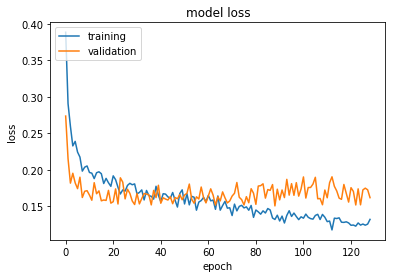

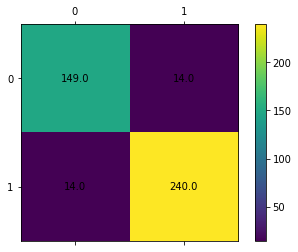

Epoch 00067: early stopping
acc: 91.85%


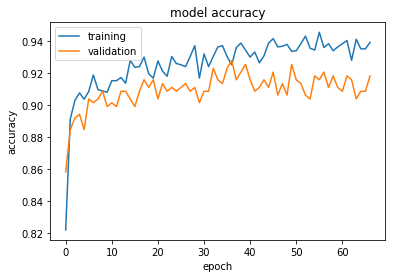

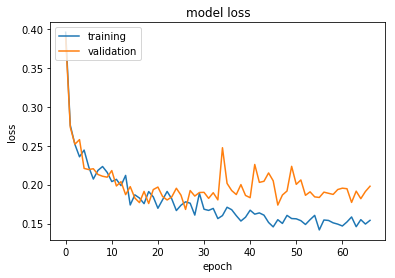

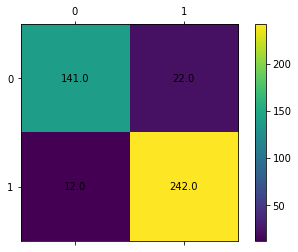

Epoch 00084: early stopping
acc: 93.05%


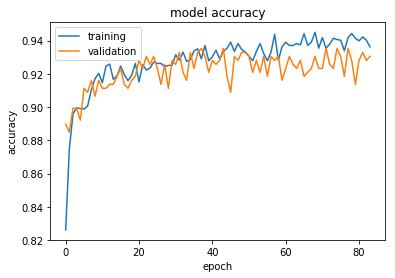

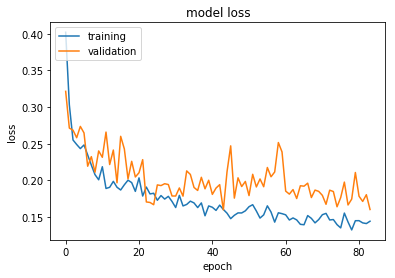

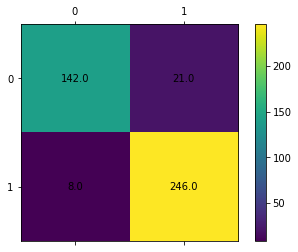

In [54]:
from sklearn.model_selection import StratifiedKFold
seed = 7
kfold_p = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores_p = []
loss_p = []
XXX = winter_pca
for train, test in kfold_s.split(XXX, y):
    
    model = init_model(features_p)
    
    X_train_kp =XXX[train].reshape(XXX[train].shape[0], XXX[train].shape[1], 1)
    X_test_kp = XXX[test].reshape(XXX[test].shape[0], XXX[test].shape[1], 1)
    history_kp = LossHistory()
    es_kp = cb.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40)
    hiss_kp = model.fit(X_train_kp, y[train], epochs=150, batch_size=32,
                callbacks=[history_kp,es_kp],
                validation_data=(X_test_kp,y[test]), verbose=0)
    scores_kp = model.evaluate(X_test_kp, y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores_kp[1]*100))
    cvscores_p.append(scores_kp[1] * 100)
    loss_p.append(scores_kp[0])
#     print(score)
    plt.plot(hiss_kp.history['acc'])
    plt.plot(hiss_kp.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    plt.plot(hiss_kp.history['loss'])
    plt.plot(hiss_kp.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper left')
    plt.show()
    conf_matrix(X_test_kp,y[test],model)

In [55]:
print('accuracy:: ',"%.2f%% (+/- %.2f%%)" % (np.mean(cvscores_p), np.std(cvscores_p)))
print('error::', "%.2f (+/- %.2f)" % (np.mean(loss_p), np.std(loss_p)))

accuracy::  93.40% (+/- 1.11%)
error:: 0.17 (+/- 0.03)


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 94.03%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 92.12%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 94.02%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 92.34%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.61%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.13%


C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\isisuser\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 91.61%
92.41% (+/- 1.09%)


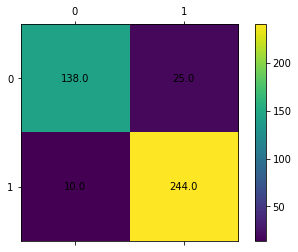

In [57]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score 
seed = 7
kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=seed)
cvscores = []
cvscm = []
for train, test in kfold.split(XXX, y):
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    
    #model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    X_train = XXX[train]
    X_test = XXX[test]
    svclassifier = SVC()
    svclassifier.fit(X_train, y[train])
    y_pred = svclassifier.predict(X_test)
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    cmw = confusion_matrix(y[test], y_pred)
    acc = accuracy_score(y[test], y_pred)*100
    print("Accuracy: %.2f%%" % acc)
    cvscores.append(acc)
    cvscm.append(cmw)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
cmavg = np.array(cvscm).mean(axis = 0)
# plt.matshow(cm)
fig, ax = plt.subplots()
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
im = ax.matshow(cmavg)
fig.colorbar(im)

for (i, j), z in np.ndenumerate(cmw):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
plt.show()